
# A small version of Josh Tenenbaum's Number Game

Based on https://github.com/probml/pmtk3/blob/master/demos/numbersGame.m

Rewritten by John Fearns - jdf22@infradead.org



In [ ]:
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

# from pyprobml_utils import save_fig

## Helper functions

# A speedy primality test for smallish numbers.
def is_prime(n):
    if n == 2 or n == 3:
        return True
    if n < 2 or n % 2 == 0:
        return False
    if n < 9:
        return True
    if n % 3 == 0:
        return False
    r = int(np.sqrt(n))
    f = 5
    while f <= r:
        # Take advantage of the fact that all primes other than 2 & 3
        # are of the form 6n +/- 1 to reduce required checks.
        if n % f == 0:
            return False
        if n % (f + 2) == 0:
            return False
        f += 6
    return True


# The range of numbers to be considered: [1,.. 100]
number_range = np.arange(1, 101)

# A hypothesis is represented by a name and a predicate. The predicate
# indicates which numbers are in the extension of the hypothesis.
class Hypothesis:
    def __init__(self, predicate, name):
        self.predicate = predicate
        self.name = name

        # The size of the extension of this hypothesis.
        self.size = sum(1 for n in number_range if self.predicate(n))

    # Returns two hypotheses: the even numbers, and the odd numbers.
    @staticmethod
    def even_odd():
        even = Hypothesis(lambda x: x % 2 == 0, "even")
        odd = Hypothesis(lambda x: x % 2 == 1, "odd")
        return [even, odd]

    # Provided with a list of integers, this function generates
    # one hypothesis for each integer: the multiples of that number.
    @staticmethod
    def multiples(multipliers):
        # Capture the value of multiplier at each iteration, not the loop variable that backs it.
        return [
            Hypothesis((lambda m: lambda x: x % m == 0)(multiplier), f"mult of {multiplier}")
            for multiplier in multipliers
        ]

    # Provided with a list of single-digit integers, this function generates
    # one hypothesis for each digit: the numbers that end in that digit.
    @staticmethod
    def ending_in(digits):
        # Capture the value of digit at each iteration, not the loop variable that backs it.
        return [Hypothesis((lambda d: lambda x: x % 10 == d)(digit), f"ends in {digit}") for digit in digits]

    # Provided with a list of integer base values greater than 1, this function generates
    # one hypothesis for each base: the numbers that are a positive integer power of
    # that base.
    @staticmethod
    def powers(bases):
        hypotheses = []

        for base in bases:
            consistent_numbers = [
                np.power(base, power) for power in range(1, 1 + int(np.floor(math.log(number_range[-1], base))))
            ]
            # Capture the current value for consistent_numbers, not the loop variable that backs it.
            hypothesis = Hypothesis((lambda c: lambda x: x in c)(consistent_numbers), f"powers of {base}")
            hypotheses.append(hypothesis)

        return hypotheses

    # Provided with a set of integers, this function generates a list containing a single hypothesis:
    # the numbers within that set.
    @staticmethod
    def explicit_set(numbers):
        return [Hypothesis(lambda x: x in numbers, "{" + ",".join([str(n) for n in numbers]) + "}")]

    # This function pairwise composes two lists of hypotheses of the same length into a single
    # list of that length. Corresponding pairs of hypotheses are composed from each list
    # using the supplied logical operation to combine the values of their predicates on numbers
    # (the operation should take two booleans and return just one).
    # operation_symbol is displayed in the composed hypothesis name so use a '+' for A or B
    # '-' for A and not B, etc.
    @staticmethod
    def compose(hypotheses1, hypotheses2, operation, operation_symbol):
        def hypotheses():
            for i in range(0, len(hypotheses1)):
                h1 = hypotheses1[i]
                h2 = hypotheses2[i]
                # Capture the values of hypothesis1 and 2, and not the variables that back them.
                yield Hypothesis(
                    (lambda h1, h2: lambda x: operation(h1.predicate(x), h2.predicate(x)))(h1, h2),
                    h1.name + operation_symbol + h2.name,
                )

        return list(hypotheses())

    # Returns the extension of the hypothesis as a list of binary indicators for each
    # of the numbers in the number range. Note: the first indicator value corresponds
    # to the first number in the range of numbers, etc.
    def get_extension_indication(self):
        return [int(self.predicate(x)) for x in number_range]

    # Returns the extension of the hypothesis as a list of numbers in the extension
    def get_extension(self):
        return [x for x in number_range if self.predicate(x)]

    # The probability under this hypothesis of generating the given number.
    def prob(self, number):
        return int(self.predicate(number)) / self.size


class Bayes:
    # Likelihood p(D|h)
    # Returns vector L, s.t. L[i] = p(D|h[i])
    @staticmethod
    def likelihood(data, hypotheses):
        # Calculate the likelihood of each data value data[i]
        # under each hypotheses hypotheses[j] and store in
        # a matrix indexed by (i,j), then take the product
        # of its entries along the data axis.
        lik = np.column_stack([[hypothesis.prob(x) for x in data] for hypothesis in hypotheses])
        return np.prod(lik, 0)

    # Posterior distribution, p(h|D) as a vector whose index positions correspond
    # to those of the hypotheses.
    @staticmethod
    def posterior(prior, likelihood):
        post = prior * likelihood
        return post / sum(post)

    # Returns the set of marginal probabilities p(x in C|D) for each x as a vector whose index
    # positions correspond to those of the number_range of x. Note: this is not a probability
    # distribution but a set of marginal probabilities.
    @staticmethod
    def posterior_concept_membership_marginals(hypotheses, posterior):
        # Get the concept membership indicators (0 or 1) for each number x and hypothesis h as a matrix.
        inconcept = np.array(np.column_stack([h.get_extension_indication() for h in hypotheses]))

        # Matrix-multiply by the posterior p(h|D) vector on the hypotheses to get the Bayesian
        # Model Average of these indicators, which will equate to p(x in C|D).
        return np.matmul(inconcept, posterior)

In [9]:
class Graphing:
    @staticmethod
    def plot_hypothesis_space(hypotheses, filename):
        # Build and display a matrix of binary values indicating membership of each number in the number
        # range (indexed by the first axis) in the extension of each hypotheses (indexed by the
        # second axis).
        image = np.column_stack([hypothesis.get_extension_indication() for hypothesis in hypotheses])

        plt.gray()
        plt.xticks(
            [i for i in range(len(hypotheses))], [hypothesis.name for hypothesis in hypotheses], rotation="vertical"
        )
        plt.yticks([0, 20, 40, 60, 80, 100])
        # Ensure the 100 label is shown.
        plt.ylim(-1, 100)
        plt.imshow(image, aspect="auto", interpolation="none", origin="lower")

        plt.tight_layout()
        plt.savefig(filename)
        # plt.savefig('../figures/{}'.format(filename))

        # Don't block, continue to show the next figure.
        plt.show(block=False)

    @staticmethod
    def plot_prior_lik_post(data, hypotheses, prior, likelihood, posterior, filename):
        plt.figure(figsize=(12, 10))
        plt.suptitle("data = {" + ",".join([str(x) for x in data]) + "}", fontsize=24, x=0.56, y=1.03)

        # sub-plot title y-alignment
        y_title_align = -0.07

        # Plot the prior.
        plt.subplot(1, 3, 1)
        plt.title("prior", y=y_title_align)
        plt.barh([i for i in range(len(hypotheses))], [prob for prob in prior[::-1]], color="blue")
        plt.yticks([i for i in range(len(hypotheses))], [hypothesis.name for hypothesis in hypotheses[::-1]])

        # Plot the likelihood.
        plt.subplot(1, 3, 2)
        plt.title("lik", y=y_title_align)
        plt.barh([i for i in range(len(hypotheses))], [lik for lik in likelihood[::-1]], color="blue")
        # plt.xticks( [] )
        plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
        # The maximum likelihood can be small. Use scientific notation.
        plt.ticklabel_format(axis="x", style="sci", scilimits=(-2, 2))

        # Plot the posterior.
        plt.subplot(1, 3, 3)
        plt.title("post", y=y_title_align)
        plt.barh([i for i in range(len(hypotheses))], [post for post in posterior[::-1]], color="blue")
        # plt.xticks([])
        plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

        plt.tight_layout()
        plt.savefig(filename)
        # plt.savefig('../figures/{}'.format(filename))

        # Don't block, continue to show the next figure.
        plt.show(block=False)

    @staticmethod
    def plot_post_membership_marginals(data, hypotheses, posterior, marginals, filename):
        # Make way for 4 plots arranged in a suitable 2x2 grid.
        figure, axes = plt.subplots(
            2,
            2,
            figsize=(12, 8),
            gridspec_kw={"width_ratios": [7, 1], "height_ratios": [2, 5]},
        )

        # x-axis limits for those subsplots with the number range on their x-axis.
        x_min = number_range[0] - 1
        x_max = number_range[-1] + 1

        # Plot the posterior membership marginals in the top-left slot.
        ax_marginals = axes[0, 0]
        ax_marginals.bar([x for x in number_range], [marginals[i] for i in range(len(number_range))], color="blue")
        ax_marginals.set_xticks(np.arange(4, number_range[-1] + 1, 4))
        ax_marginals.set_xticklabels([number_range[i] for i in np.arange(3, number_range[-1], 4)])
        ax_marginals.set_xlim(x_min, x_max)
        # Hide spines.
        ax_marginals.spines["top"].set_visible(False)
        ax_marginals.spines["right"].set_visible(False)

        # Rank the hypotheses from least to most probable and keep the 10 most probable only.
        top_n = 10
        top_10_ranked_hypotheses_posterior = np.row_stack(
            [[hypotheses[i], posterior[i]] for i in range(len(hypotheses))]
        )
        top_10_ranked_hypotheses_posterior = sorted(top_10_ranked_hypotheses_posterior, key=lambda row: row[1])
        top_10_ranked_hypotheses_posterior = top_10_ranked_hypotheses_posterior[-top_n:]

        # Calculate scatter points for the hypotheses extensions subplot.
        extension_points = [
            [x, i] for i in range(top_n) for x in top_10_ranked_hypotheses_posterior[i][0].get_extension()
        ]

        # Plot the hypotheses extensions in the lower-left slot.
        ax_extensions = axes[1, 0]
        ax_extensions.set_ylim(0, top_n - 1)
        ax_extensions.set_xlim(x_min, x_max)
        ax_extensions.set_yticks([i for i in range(top_n)])
        ax_extensions.set_yticklabels([top_10_ranked_hypotheses_posterior[i][0].name for i in range(top_n)])
        # Disable y-axis ticks.
        ax_extensions.tick_params(
            axis="y",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            left=False,  # ticks along the left edge are off
            right=False,
        )  # ticks along the right edge are of
        # Disable x-axis ticks and labels.
        ax_extensions.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )  # labels along the bottom edge are off
        # Show horizontal grid lines.
        ax_extensions.grid(axis="y", which="major", color="grey")
        # Ensure the horizonal grid lines are rendered underneath scatter points.
        ax_extensions.set_axisbelow(True)
        # No grid line is shown at the bottom, so show the bottom spine in their style.
        ax_extensions.spines["bottom"].set_color("grey")
        ax_extensions.spines["bottom"].set_zorder(-10)
        # Hide other spines
        ax_extensions.spines["top"].set_visible(False)
        ax_extensions.spines["left"].set_visible(False)
        ax_extensions.spines["right"].set_visible(False)
        # Prevent clipping of scatter points at subplot boundaries using clip_on=False.
        ax_extensions.scatter(
            [point[0] for point in extension_points],
            [point[1] for point in extension_points],
            color="blue",
            clip_on=False,
        )

        # Calculate plot points for the posterior distribution subplot.
        ax_posterior = axes[1, 1]
        # Prevent clipping of scatter points at subplot boundaries using clip_on=False.
        ax_posterior.plot(
            [top_10_ranked_hypotheses_posterior[i][1] for i in range(top_n)],
            [i for i in range(top_n)],
            color="blue",
            marker="o",
            clip_on=False,
        )
        ax_posterior.set_ylim(0, top_n - 1)
        ax_posterior.spines["top"].set_visible(False)
        ax_posterior.spines["right"].set_visible(False)
        # Disable y-axis ticks and labels.
        ax_posterior.tick_params(
            axis="y",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            left=False,  # ticks along the left edge are off
            right=False,  # ticks along the right edge are off
            labelleft=False,
        )  # labels along the left edge are off
        ax_posterior.set_title(r"$p(h|{})$".format(",".join([str(x) for x in data])), y=-0.12)

        # Hide the axes of the plot in the top-right slot.
        axes[0, 1].axis("off")

        plt.tight_layout()
        plt.savefig(filename)
        # plt.savefig('../figures/{}'.format(filename))
        plt.show()

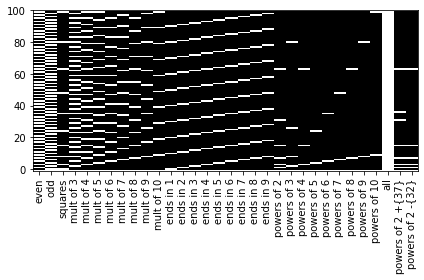

In [10]:
# The hypothesis space: a vector of hypotheses.
hypotheses = (
    Hypothesis.even_odd()
    + [Hypothesis(lambda x: x == np.floor(0.5 + np.sqrt(x)) ** 2, "squares")]
    + Hypothesis.multiples(np.arange(3, 11))
    + Hypothesis.ending_in(np.arange(1, 10))
    + Hypothesis.powers(np.arange(2, 11))
    + [Hypothesis(lambda x: True, "all")]
    + Hypothesis.compose(Hypothesis.powers([2]), Hypothesis.explicit_set([37]), lambda x, y: x or y, " +")
    + Hypothesis.compose(Hypothesis.powers([2]), Hypothesis.explicit_set([32]), lambda x, y: x and not y, " -")
)

# The prior on the hypothesis space (a 1-d vector).
# {odd,even} = 0.5 ; {powers of 2 + 37,powers of 2 - 32} = 0.001; else=0.1
prior = np.concatenate([np.array([0.5, 0.5]), 0.1 * np.ones(28), np.array([0.001, 0.001])])
prior = prior / np.sum(prior)


Graphing.plot_hypothesis_space(hypotheses, "numbersGameHypothesisSpace.pdf")

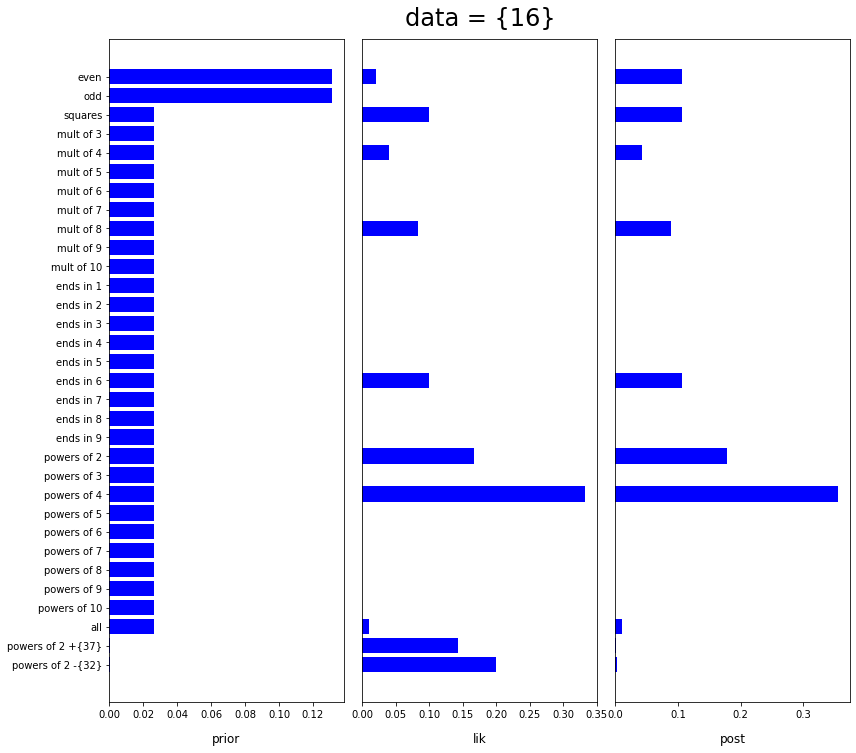

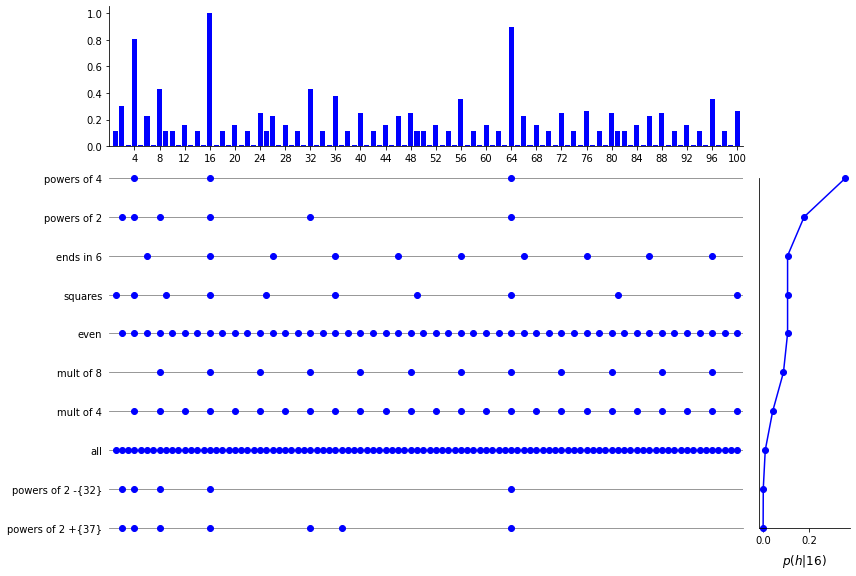

In [11]:
# Calculations for D={16}
data_16 = [16]
likelihood_16 = Bayes.likelihood(data_16, hypotheses)
posterior_16 = Bayes.posterior(prior, likelihood_16)
post_marginals_16 = Bayes.posterior_concept_membership_marginals(hypotheses, posterior_16)

Graphing.plot_prior_lik_post(data_16, hypotheses, prior, likelihood_16, posterior_16, "numbersGamePriorLikPost16.pdf")
Graphing.plot_post_membership_marginals(
    data_16, hypotheses, posterior_16, post_marginals_16, "numbersGamePostMembership16.pdf"
)

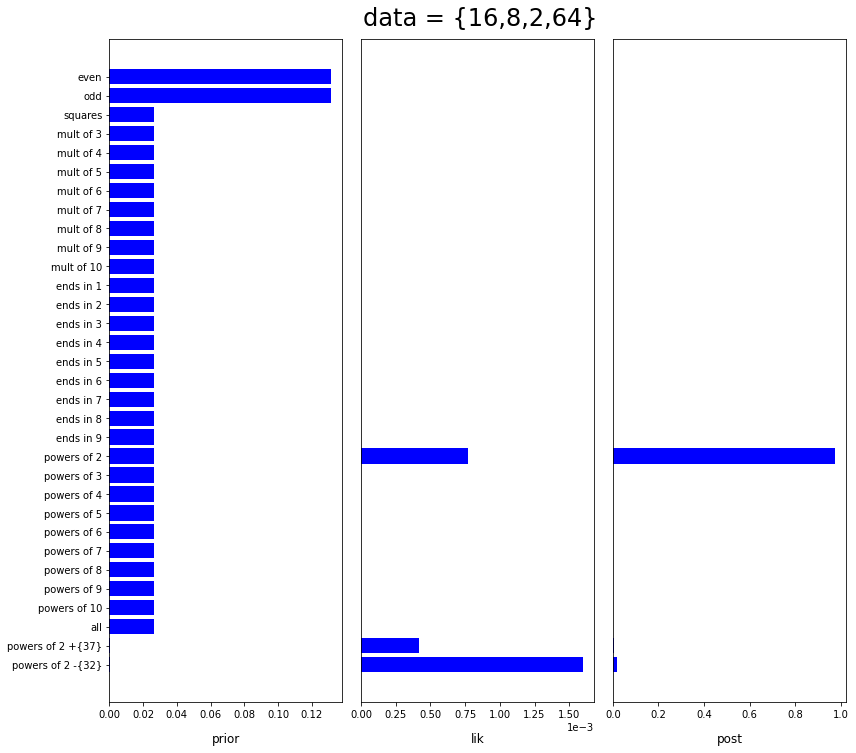

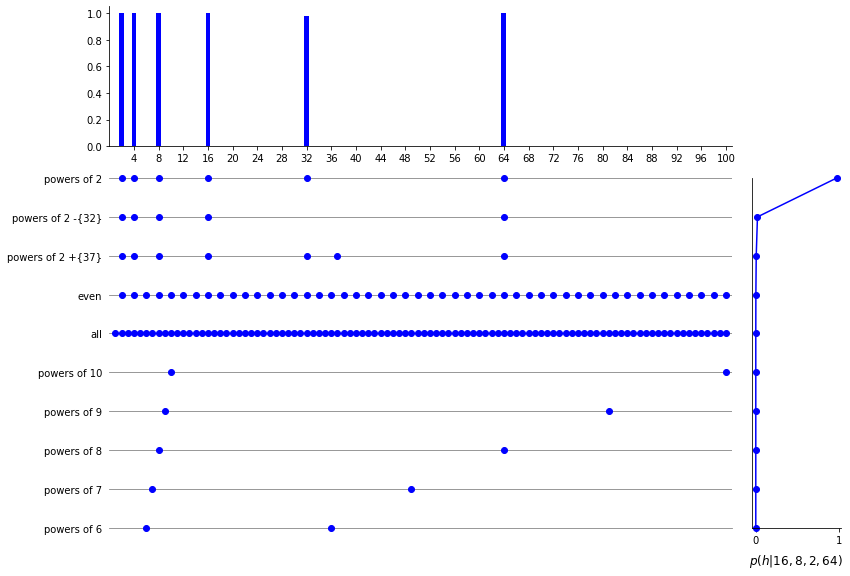

In [12]:
# Calculations for D={16, 8, 2, 64}
data_all = [16, 8, 2, 64]
likelihood_all = Bayes.likelihood(data_all, hypotheses)
posterior_all = Bayes.posterior(prior, likelihood_all)
post_marginals_all = Bayes.posterior_concept_membership_marginals(hypotheses, posterior_all)

Graphing.plot_prior_lik_post(
    data_all, hypotheses, prior, likelihood_all, posterior_all, "numbersGamePriorLikPostAll.pdf"
)
Graphing.plot_post_membership_marginals(
    data_all, hypotheses, posterior_all, post_marginals_all, "numbersGamePostMembershipAll.pdf"
)